# Images of cloud reflectance around cold pools identified at the Ron Brown during ATOMIC.

Copyright 2025 Simon P. de Szoeke and Estefanía Quiñones 
Meléndez.

Permission is hereby granted, free of charge, to any person 
obtaining a copy of this software and associated documentation 
files (the “Software”), to deal in the Software without 
restriction, including without limitation the rights to use, 
copy, modify, merge, publish, distribute, sublicense, and/or 
sell copies of the Software, and to permit persons to whom the 
Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be 
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, 
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES 
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING 
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
OTHER DEALINGS IN THE SOFTWARE.

In [1]:
# set up an environment with required packages

# Activate the current directory's environment 
using Pkg; Pkg.activate(".")

# add required packages, if needed
#=
Pkg.add([
    "Revise",
    "DataFrames",
    "CSV",
    "Statistics",
    "Distances",
    "PyCall",
    "PyPlot",
    "FileIO",
    "NCDatasets"
])
=#

  Activating project at `~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB`


In [2]:
# using packages

using Pkg; Pkg.activate(".")

using Printf
using Dates
using FileIO
using NCDatasets
using DataFrames
using CSV

using Statistics
using Distances

using PyPlot

  Activating project at `~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB`


In [3]:
# PyPlot setup

using PyCall
using PyCall: PyObject

# extend PyObject to maskedarray to allow for plotting with missing values
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

# check if Helvetica font is available
for font in PyPlot.matplotlib["font_manager"]["findSystemFonts"]()
    if occursin("Helvetica", font)
        println(font)
    end
end

myfonts = PyPlot.matplotlib["font_manager"]["findSystemFonts"]()
ff = [occursin("Helvetica", font) for font in myfonts]
if any(occursin("Helvetica", font) for font in myfonts)
    # println("Helvetica fonts found:")
    # for font in fonts
    #     if occursin("Helvetica", font)
    #         println(font)
    #     end
    # end
    # silently set font to Helvetica if available
    rc("font", family="Helvetica")
else
    println("Helvetica font not found; trying default sans serif font.")
    rc("font", family="sans-serif")
    rc("font", sans_serif=["Helvetica", "Arial", "Verdana"])
end
# rc("font", family="sans-serif")
# rc("font", sans_serif=["Helvetica"])

mcolors = PyPlot.matplotlib.colors

/System/Library/Fonts/Helvetica.ttc
/opt/X11/share/system_fonts/HelveticaNeue.ttc
/System/Library/Fonts/HelveticaNeue.ttc
/opt/X11/share/system_fonts/Helvetica.ttc


PyObject <module 'matplotlib.colors' from '/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/colors.py'>

In [4]:
# read cold pool time, lat,lon from csv file

# coldpooltable = "/home/server/pi/homes/sdeszoek/ATOMIC/RHB/coldpool_tmin.csv"
coldpooltable = "./coldpool_tmin.csv"
cpt = CSV.read( coldpooltable, DataFrame )
# these event:
cpt.datestringUTC[[18, 22]]

rd20(t) = round(t, Minute(20), RoundDown )
cpdt = map(x -> DateTime( x , dateformat"dd-u-yyyy HH:MM:SS" ), cpt.datestringUTC)
cpdt0 = round.(cpdt, Minute(20), RoundDown )
# cpdt1 = round.(cpdt, Minute(20), RoundUp )
cpdt1 = cpdt0 .+ Minute(20)
cpdt0[[18,22]]
readdir() |> filter( startswith("G16V04.0.ATOMIC.") )

4-element Vector{String}:
 "G16V04.0.ATOMIC.2020039.1800.PX.02K.NC"
 "G16V04.0.ATOMIC.2020039.1820.PX.02K.NC"
 "G16V04.0.ATOMIC.2020041.1620.PX.02K.NC"
 "G16V04.0.ATOMIC.2020041.1640.PX.02K.NC"

In [5]:
# find RHB to make center of GOES plot domain

"Find the center indices for gridlat,gridlon nearest query lat,lon."
function find_ctr_ij(gridlat, gridlon, lat, lon)
   valid_mask = .!ismissing.(gridlat) .& .!ismissing.(gridlon)
   inds = findall( valid_mask ) # indices of valid lat,lon pairs
   # X = permutedims([[gridlat[i], gridlon[i]] for i in inds])'
   X = mapreduce(i -> [gridlat[i]; gridlon[i]], hcat, inds)
   Y = [lat; lon] # one vector of scalars lat, lon
   ind = argmin( colwise(Cityblock(), X, Y) ) # linear index of minimal distance to query
   # Cityblock() -> sum(abs(x-y)) is more efficient than Euclidean.
   # convert linear to Cartesian index
   ic, jc = Tuple( inds[ind] )
   return ic, jc
   # do not reverse order, refl[ic, jc] lat,lon index
end


find_ctr_ij

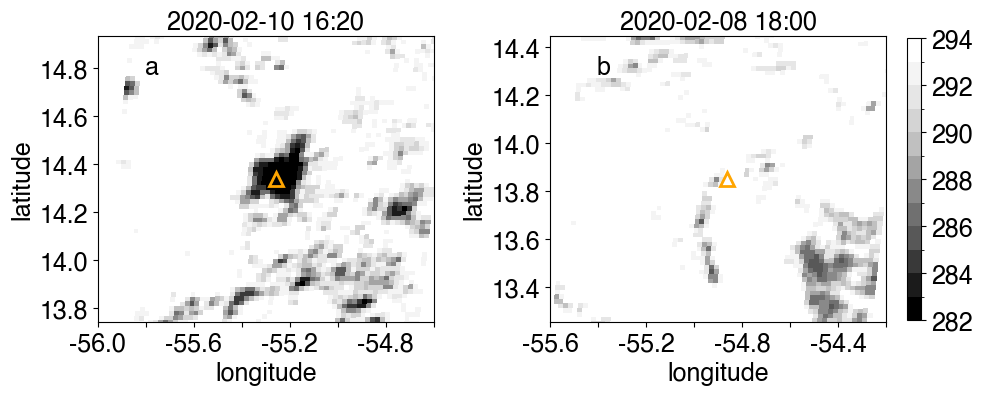

In [6]:
# plot Tir images centered around RHB cold pools

close("all")

# Define boundaries and colormap
cbounds = 282:294  # levels at 0, 2, 4, 6, 8, 10
norm = mcolors.BoundaryNorm(cbounds, length(cbounds) - 1)
cm = PyPlot.matplotlib.cm
cmap = cm.get_cmap("Greys_r", length(cbounds) - 1)

nx = 32
wd = 72
idx = [22, 18]
fsz = 18
joy(dt) = @sprintf("%04d%03d.%02d%02d", year(dt), dayofyear(dt), hour(dt), minute(dt))

# make the Tir image for each cold pool
clf()
fig, axs = subplots(1,2, figsize=(10,5))
# fig.suptitle("GOES-16 infrared temperature", fontsize=18)
for (i, ax) in enumerate(axs)
    k = idx[i]
    # ax = axs[i]
    # get data and subset
    filename = "G16V04.0.ATOMIC.$(joy(cpdt0[k])).PX.02K.NC"
    ds = NCDatasets.NCDataset( filename )
    glat = ds["latitude"][:,:]
    glon = ds["longitude"][:,:]
    ilat, ilon = find_ctr_ij(glat, glon, cpt.lat[k], cpt.lon[k])
    iilat = ilat-nx:ilat+nx # subset image
    iilon = ilon-nx:ilon+nx
    # iilat = ilat+nx:-1:ilat-nx # subset image backwards - no change
    # iilon = ilon+nx:-1:ilon-nx
    tir  = ds["temperature_ir"][iilat, iilon]
    # ref = ds["reflectance_vis"][iilat, iilon]

    # format dates
    df  = Dates.format(cpdt[k], dateformat"yyyy-mm-ddTHH_MM")
    dfp = Dates.format(cpdt[k], dateformat"yyyy-mm-dd HH:MM")
    dfp0 = Dates.format(cpdt0[k], dateformat"yyyy-mm-dd HH:MM")

    x = glon[iilat, iilon]
    y = glat[iilat, iilon]
    z = tir
    
    xdeg2km = 111.0*cosd(cpt.lat[k])
    half = 2.2*30/111 # degree

    pc = ax.pcolormesh(x,y, z, cmap=cmap, norm=norm,
            rasterized=true)
    cb = fig.colorbar(pc, ax=ax, boundaries=cbounds, shrink=0.60)
    cb.ax.tick_params(labelsize=18)
    i==1 ? cb.ax.set_visible(false) : cb.ax.set_visible(true)
    ax.plot(cpt.lon[k],cpt.lat[k], marker="^", markersize=10, markeredgewidth=2, color="orange", fillstyle="none")

    ax.set_xlim([cpt.lon[k]-half, cpt.lon[k]+half])
    ax.set_ylim([cpt.lat[k]-half, cpt.lat[k]+half])
    ax.text(cpt.lon[k]-0.87*half, cpt.lat[k]+0.7*half, "$('a'-1+i)", 
        horizontalalignment="center", verticalalignment="bottom", fontsize=fsz)
    # xt, xl = xticks()
    # new_labels = [i % 2 == 0 ? string(lbl) : " " for (i, lbl) in enumerate(xt)]
    # xticks(xt,new_labels; fontsize=fsz)
    xticks = ax.get_xticks()
    labels = [i % 2 !==0 ? string(round(tick; digits=2)) : "" for (i, tick) in enumerate(xticks)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    # xticks(fontsize=fsz)
    yticks(fontsize=fsz)
    for tick in [ax.get_xticklabels(); ax.get_yticklabels()]
        tick.set_fontsize(fsz)
    end
    ax.set_aspect(1)
    ax.set_title( "$(dfp0)", fontsize=fsz )
    ax.set_xlabel("longitude", fontsize=fsz)
    ax.set_ylabel("latitude", fontsize=fsz)
end

tight_layout()
gcf()

In [ ]:
# save the figure

fmts = ["png", "svg", "eps", "pdf"]
# [savefig("coldpool_tir_0208_0210.$(f)") for f in fmts]